# IBM Applied Data Science Capstone Project

<div class="alert alert-block alert-info">
    Blue Divider is used for Each Part
    <br> 
    <br>Part 1 -  
<br>	1. A description of the problem and a discussion of the background.
<br>	2. A description of the data and how it will be used to solve the problem.
    <br>
    <br>
</div>

Use this link - https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q=los+angeles&rows=18&facet=state&facet=timezone&facet=dst

### Probem Statement: <br> The client want to know suitable neighborhood to open a fast food restaurant in Los Angeles.
#### In order to do this, we need to answer the following questions <br> 1) What are the suitable neighborhoods in Los Angeles for a new Fast Food Restaurant? <br> 2) Which areas have potential Fast Food Restaurant Market? <br> 3) Which areas are lacking Fast Food Restaurants?

##### To answer the above questions, we need to <br> 1) We need to analyze number of restarants in each neighborhood <br> 2) Population density of each neighborhood <br> 3) Select the neighborhood that has lowest restarant to population density ratio

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import string
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import matplotlib.pyplot as plt


<div class="alert alert-block alert-info">
    <br>Get neighborhoods, Latitude and Longitude of Los Angeles
    <br>
    <br>
</div>

Orther urls tried

https://public.opendatasoft.com/api/records/1.0/search/?dataset=us-zip-code-latitude-and-longitude&q=los+angeles&rows=200&facet=state&facet=timezone&facet=dst

https://www.laalmanac.com/communications/cm02_communities.php#:~:text=Postal%20Zip%20Codes%20by%20Community%20Los%20Angeles%20County,%20%2091390%20%2061%20more%20rows%20

https://www.laalmanac.com/communications/cm02a90001-90899.php

### Start webscraping by submiting a request to read html content from the web page

In [2]:
url = 'http://maps.latimes.com/neighborhoods/neighborhood/list/'
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, 'html.parser')
tables = soup.find_all('table')
table_index = 0
n_count = len(tables[table_index].tbody.findAll('tr'))
print("Number of neighborhoods codes: ", n_count)

Number of neighborhoods codes:  272


### Read each neighborhood from the web page and get longitude and latidue at the same time using Geopy library

In [3]:
# Get the neighborhoods and their geo locations... this takes time and sometimes fail. so I did it porttion of data at a time and saved it to my PC
# geolocator = Nominatim(user_agent="geoapiExercises1")
# 
# table_contents=[]
# i = 0
# for row in tables[table_index].tbody.findAll('tr'):
#     c = row.findAll('a')
#     cell = {}
#     if c == None:
#         pass
#     else:
#         cell['Neighborhood'] = c[0].text
#         cell['Region'] = c[1].text
#         geo_ll = geolocator.geocode(c[0].text + ', CA, USA')
#         if geo_ll:
#             cell['Address'] = geo_ll.address
#             cell['Latitude'] = geo_ll.latitude
#             cell['Longitude'] = geo_ll.longitude
#             table_contents.append(cell)
#         else:
#             print('unable to find geo location for ' + c[0].text)
#     if i in [20, 40, 60, 80, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]:
#         print(i)
#     i = i + 1
# 
# df_postal_codes_with_ll = pd.DataFrame(table_contents)

##### I saved the data fetched from above code into a file for later use.... as getting geo codes takes too long and times out sometimes : )

df_postal_codes_with_ll = pd.read_csv('la_data.csv')

In [4]:
# Review the data
print(df_postal_codes_with_ll.shape)
df_postal_codes_with_ll.head(10)

(265, 5)


,Neighborhood,Region,Address,Latitude,Longitude
0,Acton,Antelope Valley,"Acton, California, United States",34.480742,-118.186838
1,Adams-Normandie,South L.A.,"Adams-Normandie, Los Angeles, California, Unit...",34.031788,-118.300247
2,Agoura Hills,Santa Monica Mountains,"Agoura Hills, California, 91301, United States",34.147910,-118.765704
3,Agua Dulce,Northwest County,"Agua Dulce, California, United States",34.496382,-118.325635
4,Alhambra,San Gabriel Valley,"Alhambra, California, United States",34.093042,-118.127060
5,Alondra Park,South Bay,"Alondra Park, California, 90506, United States",33.890134,-118.335139
6,Altadena,Verdugos,"Altadena, California, 91001, United States",34.186316,-118.135233
7,Angeles Crest,Angeles Forest,Los Angeles Air Force Base (Pacific Crest Hous...,33.720966,-118.311107
8,Arcadia,San Gabriel Valley,"Arcadia, California, United States",34.136207,-118.040150
9,Arleta,San Fernando Valley,"Arleta, Los Angeles, California, United States",34.241327,-118.432205


### Get population density for each neighborhood
From: http://maps.latimes.com/neighborhoods/population/density/neighborhood/list/

In [5]:
url = 'http://maps.latimes.com/neighborhoods/population/density/neighborhood/list/'
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, 'html.parser')
tables = soup.find_all('table')
table_index = 0
for i, t in enumerate(tables):
    if("Population per Sqmi" in str(t)):
        table_index = i

n_count = len(tables[table_index].tbody.findAll('tr'))
print("Table index: ",table_index)
print("Number of neighborhoods: ", n_count)


Table index:  1
Number of neighborhoods:  265


In [6]:
table_contents=[]
i = 0
for row in tables[table_index].tbody.findAll('tr'):
    c = row.findAll('td')
    cell = {}
    if c == None:
        pass
    else:
        cell['Neighborhood'] = c[1].a.text.strip()
        cell['Population per Sqmi'] = c[2].text.replace(',','').strip()
        table_contents.append(cell)

df_population_density = pd.DataFrame(table_contents)
df_population_density.head(10)

,Neighborhood,Population per Sqmi
0,Koreatown,42611
1,Westlake,38214
2,East Hollywood,31095
3,Pico-Union,25352
4,Maywood,23638
5,Harvard Heights,23473
6,Hollywood,22193
7,Walnut Park,22028
8,Palms,21870
9,Adams-Normandie,21848


In [7]:
# Merge both data frames
df_la = df_postal_codes_with_ll.merge(df_population_density, on='Neighborhood')


print('df_postal_codes_with_ll: ', df_postal_codes_with_ll.shape)
print('df_postal_codes_with_ll: ', df_postal_codes_with_ll.shape)
print('df_la: ', df_la.shape)

df_postal_codes_with_ll:  (265, 5)
df_postal_codes_with_ll:  (265, 5)
df_la:  (258, 6)


In [8]:
df_la.head()

,Neighborhood,Region,Address,Latitude,Longitude,Population per Sqmi
0,Acton,Antelope Valley,"Acton, California, United States",34.480742,-118.186838,166
1,Adams-Normandie,South L.A.,"Adams-Normandie, Los Angeles, California, Unit...",34.031788,-118.300247,21848
2,Agoura Hills,Santa Monica Mountains,"Agoura Hills, California, 91301, United States",34.147910,-118.765704,2495
3,Agua Dulce,Northwest County,"Agua Dulce, California, United States",34.496382,-118.325635,99
4,Alhambra,San Gabriel Valley,"Alhambra, California, United States",34.093042,-118.127060,11275


### Now get restuarants around each neighborhood using Foursquare API, along with ratings

In [9]:
### Define foursquare functions
CLIENT_ID = 'RCC5BSXF22GXO2SAVHVNDQPMJ1YGV10ZR4VHDIRAW3RSF5TA' # your Foursquare ID
CLIENT_SECRET = '1A5ZAXGZ4QK33KUK3UWTR4ZQ3CQYCNM425C4SPEUXENAN5TZ' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20200401' # Foursquare API version
CATEGORY_ID='4bf58dd8d48988d16e941735' # Refer this for link of categories https://developer.foursquare.com/docs/build-with-foursquare/categories/
CATEGORY_NAME = 'Fast Food Restaurant'
RADIUS=500
LIMIT=100

In [10]:
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [11]:
column_names=['Region', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Venue ID']
restaurants=pd.DataFrame(columns=column_names)
neibhorhoods = pd.DataFrame(columns=['Region', 'Neighborhood', 'Latitude', 'Longitude', 'Population per Sqmi', 'Restaurant Count', 'Restaurant to Population Ratio'])

count = 1

# LOOP THROUGH EACH NEIGHBORHOOD AND GET VENUES
for row in df_la.loc[:,['Region', 'Neighborhood', 'Latitude', 'Longitude', 'Population per Sqmi']].values.tolist():
    Region, Neighborhood, Latitude, Longitude, Population = row
    venue_details=[]
    
    # GET VENUES FROM FOURSQUARE
    url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CATEGORY_ID,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        Latitude, 
        Longitude, 
        RADIUS, 
        LIMIT)
    venue_data = requests.get(url).json()["response"]['groups'][0]['items']
    
    # INSERT VENUES INTO A DATA FRAME
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_lat=row['venue']['location']['lat'], 
            venue_lng=row['venue']['location']['lng'],  
            venue_category=row['venue']['categories'][0]['name']
            venue_category_id=row['venue']['categories'][0]['id']
            venue_details.append([Region, Neighborhood, Latitude, Longitude, venue_name, venue_lat[0], venue_lng[0], venue_category, venue_id])
        except KeyError:
            pass

    if len(venue_details) > 0:
        # print('(',count,'/',len(df_la),')','Fast Food Resturants in '+Neighborhood+', '+Region+':'+str(len(venues)))

        venues = pd.DataFrame([item for venue_list in venue_details for item in venue_details])
        venues.columns = column_names
        restaurants = restaurants.append(venues, ignore_index=True)
        # print([Region, Neighborhood, Latitude, Longitude, Population,  len(venue_details), 0])
        neibhorhoods = neibhorhoods.append({
                                            'Region' : Region, 
                                            'Neighborhood' : Neighborhood, 
                                            'Latitude' : Latitude, 
                                            'Longitude' : Longitude, 
                                            'Population per Sqmi' : int(Population), 
                                            'Restaurant Count' : len(venue_details), 
                                            'Restaurant to Population Ratio' : (len(venue_details) / int(Population))
                                           },
                                            ignore_index=True)
    count+=1
    if count == 50:
        print(count)
    elif count == 100:
        print(count)
    elif count == 150:
        print(count)
    elif count == 200:
        print(count)
    elif count == 250:
        print(count)

50
100
150
200
250


In [12]:
print("Neighborhoods data frame shape: ", neibhorhoods.shape)
print("Restaurants data frame shape: ", restaurants.shape)
restaurants.head()

Neighborhoods data frame shape:  (138, 7)
Restaurants data frame shape:  (1647, 9)


,Region,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
0,Santa Monica Mountains,Agoura Hills,34.147910,-118.765704,Blimpie,34.147968,-118.760353,Fast Food Restaurant,4f3258d019836c91c7cec5a2
1,San Gabriel Valley,Alhambra,34.093042,-118.127060,Grill 'Em All,34.095595,-118.126725,Fast Food Restaurant,50f5bbc5d86c446d680a98af
2,San Gabriel Valley,Alhambra,34.093042,-118.127060,SUBWAY,34.094359,-118.128165,Fast Food Restaurant,4b9e9cbdf964a520bef336e3
3,San Gabriel Valley,Alhambra,34.093042,-118.127060,Bon Appétea,34.093905,-118.128832,Café,53bb56c3498e1eb378326cae
4,San Gabriel Valley,Alhambra,34.093042,-118.127060,Grill 'Em All,34.095595,-118.126725,Fast Food Restaurant,50f5bbc5d86c446d680a98af


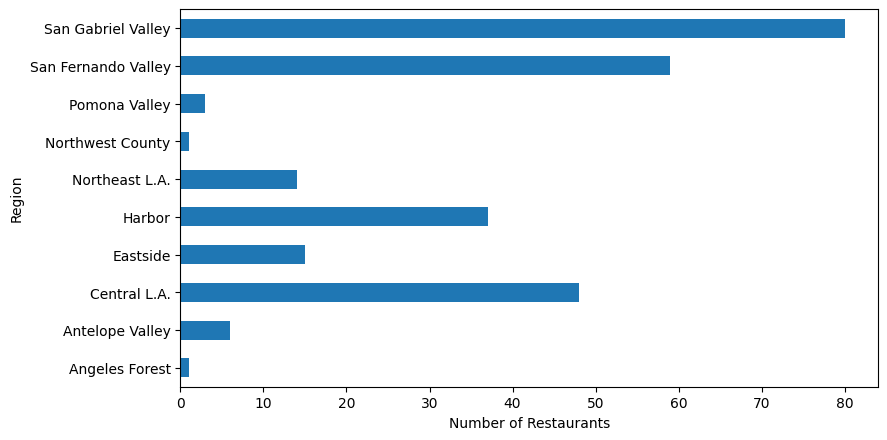

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
plt.xlabel('Number of Restaurants')
neibhorhoods.sort_values(['Restaurant Count'],ascending=False).groupby('Region')['Restaurant Count'].sum().head(10).plot.barh()
plt.show()

### Calls to get details for venue are premium with a limit of 500 calls per day, we will refer to saved data sheet csv if required.



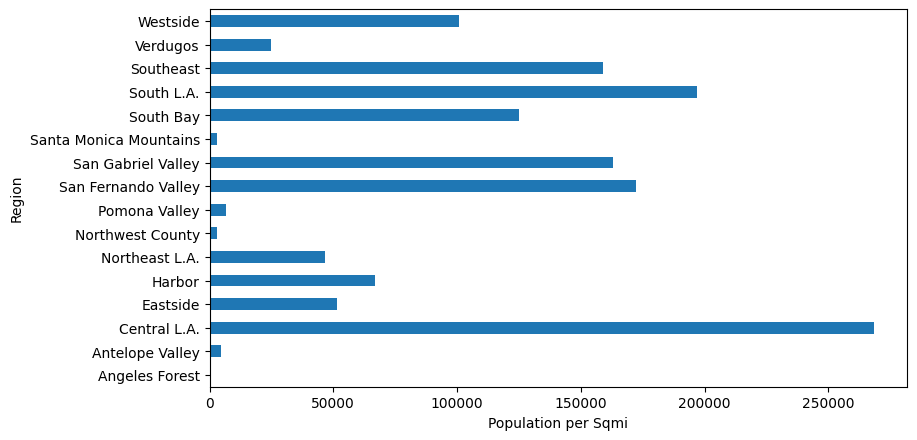

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
plt.xlabel('Population per Sqmi')
neibhorhoods.sort_values(['Population per Sqmi'],ascending=False).groupby('Region')['Population per Sqmi'].sum().head(20).plot.barh()
#neibhorhoods.sort_values(['Population per Sqmi'],ascending=False).head(15).groupby('Neighborhood')['Population per Sqmi'].sum().plot.barh()
plt.show()

In [30]:
df_regions = neibhorhoods.sort_values(['Population per Sqmi'],ascending=False).groupby('Region')['Restaurant Count','Population per Sqmi'].sum().head(20).reset_index()

<ipython-input-30-382553eda3f9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_regions = neibhorhoods.sort_values(['Population per Sqmi'],ascending=False).groupby('Region')['Restaurant Count','Population per Sqmi'].sum().head(20).reset_index()


In [28]:
df.sort_values(['Population per Sqmi'],ascending=False).head(10)

,Region,Neighborhood,Latitude,Longitude,Population per Sqmi,Restaurant Count,Restaurant to Population Ratio
61,Central L.A.,Koreatown,34.061794,-118.305447,42611,8,0.000188
129,Central L.A.,Westlake,34.062923,-118.272820,38214,4,0.000105
33,Central L.A.,East Hollywood,34.090428,-118.296625,31095,1,0.000032
91,Central L.A.,Pico-Union,34.046567,-118.287894,25352,2,0.000079
77,Southeast,Maywood,33.986681,-118.185349,23638,3,0.000127
49,Central L.A.,Harvard Heights,34.047111,-118.305483,23473,1,0.000043
55,Central L.A.,Hollywood,34.098003,-118.329523,22193,4,0.000180
123,Southeast,Walnut Park,33.969276,-118.223991,22028,2,0.000091
69,South Bay,Lennox,33.939031,-118.357443,21557,1,0.000046
56,Southeast,Huntington Park,33.982704,-118.212034,20223,1,0.000049


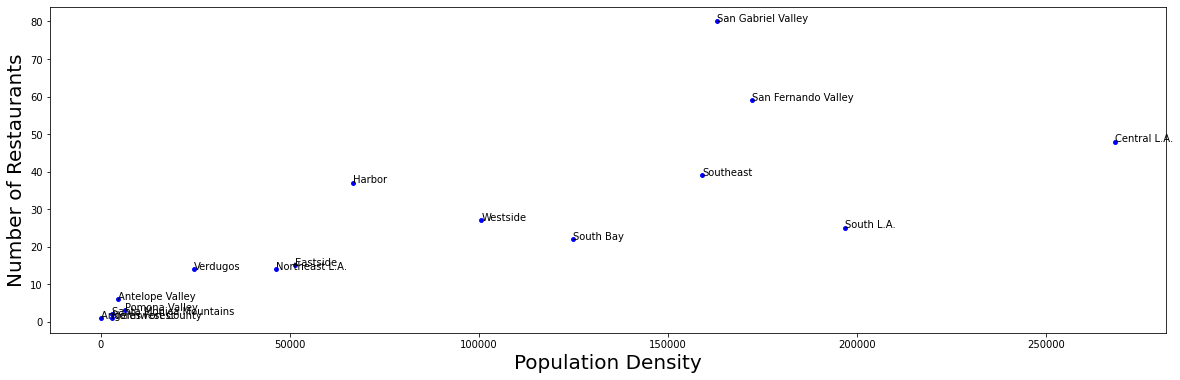

In [31]:
fig = plt.figure(1,figsize=(20,6))
plt.subplot(111)
plt.scatter(df_regions['Population per Sqmi'], df_regions['Restaurant Count'],  marker='o', color='b', s=15)

for i, row in df_regions.iterrows():
    plt.annotate(row["Region"], xy=(row["Population per Sqmi"],row["Restaurant Count"]))

plt.xlabel('Population Density',size=20)
plt.ylabel('Number of Restaurants',size=20)

plt.show()

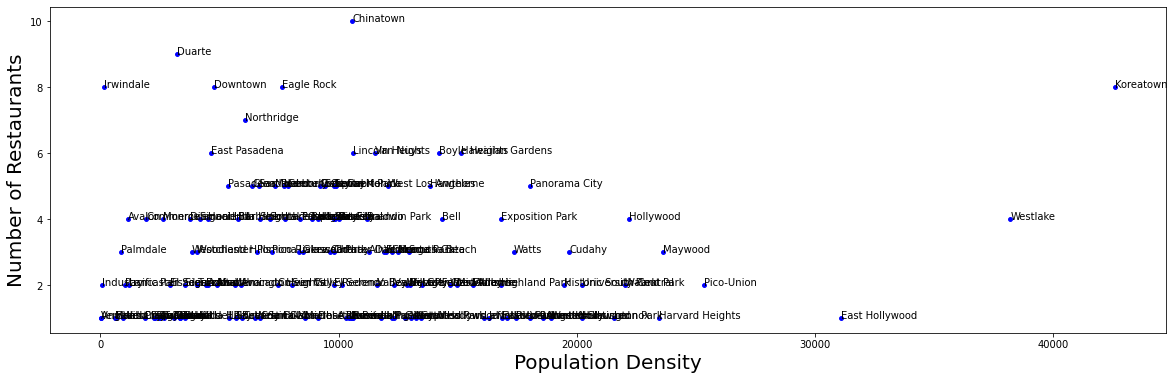

In [87]:
fig = plt.figure(1,figsize=(20,6))
plt.subplot(111)
plt.scatter(neibhorhoods['Population per Sqmi'], neibhorhoods['Restaurant Count'],  marker='o', color='b', s=15)

for i, row in neibhorhoods.iterrows():
    plt.annotate(row["Neighborhood"], xy=(row["Population per Sqmi"],row["Restaurant Count"]))

plt.xlabel('Population Density',size=20)
plt.ylabel('Number of Restaurants',size=20)

plt.show()

In [35]:
df_regions['region_ration'] = df_regions["Restaurant Count"]/df_regions["Population per Sqmi"]

In [85]:
df_regions.sort_values(['region_ration']).tail(10)

,Region,Restaurant Count,Population per Sqmi,region_ration
5,Northeast L.A.,14,46481,0.000301
6,Northwest County,1,3076,0.000325
8,San Fernando Valley,59,172279,0.000342
7,Pomona Valley,3,6556,0.000458
9,San Gabriel Valley,80,163145,0.000490
4,Harbor,37,66824,0.000554
14,Verdugos,14,24684,0.000567
10,Santa Monica Mountains,2,3124,0.000640
1,Antelope Valley,6,4529,0.001325
0,Angeles Forest,1,3,0.333333


In [91]:
neibhorhoods.sort_values(['Population per Sqmi'],ascending=False).tail(10)

,Region,Neighborhood,Latitude,Longitude,Population per Sqmi,Restaurant Count,Restaurant to Population Ratio
5,Harbor,Avalon,33.342210,-118.327261,1159,4,0.003451
84,Westside,Pacific Palisades,34.048064,-118.526471,1048,2,0.001908
133,San Gabriel Valley,West San Dimas,34.106159,-117.809712,937,1,0.001067
86,Antelope Valley,Palmdale,34.579313,-118.117111,874,3,0.003432
13,San Gabriel Valley,Bradbury,34.146951,-117.970898,658,1,0.001520
74,Santa Monica Mountains,Malibu,34.035591,-118.689423,629,1,0.001590
59,San Gabriel Valley,Irwindale,34.106993,-117.934215,154,8,0.051948
57,San Gabriel Valley,Industry,34.019734,-117.958675,82,2,0.024390
121,Southeast,Vernon,34.007135,-118.225250,18,1,0.055556
3,Angeles Forest,Angeles Crest,33.720966,-118.311107,3,1,0.333333


In [88]:
neibhorhoods.sort_values(['Restaurant to Population Ratio'],ascending=True).head(10)

,Region,Neighborhood,Latitude,Longitude,Population per Sqmi,Restaurant Count,Restaurant to Population Ratio
33,Central L.A.,East Hollywood,34.090428,-118.296625,31095,1,0.000032
49,Central L.A.,Harvard Heights,34.047111,-118.305483,23473,1,0.000043
69,South Bay,Lennox,33.939031,-118.357443,21557,1,0.000046
56,Southeast,Huntington Park,33.982704,-118.212034,20223,1,0.000049
128,Central L.A.,West Hollywood,34.092301,-118.369289,18924,1,0.000053
120,South L.A.,Vermont-Slauson,33.983691,-118.291542,18577,1,0.000054
119,South L.A.,Vermont Knolls,33.966819,-118.291670,18057,1,0.000055
90,Westside,Pico-Robertson,34.053269,-118.386983,17468,1,0.000057
131,South L.A.,Westmont,33.941403,-118.302296,17066,1,0.000059
34,Eastside,East Los Angeles,34.023902,-118.172016,16863,1,0.000059


In [82]:
selected_neighborhood = 'East Hollywood'
potential_neighborhoods = '("East Hollywood", "Harvard Heights", "Lennox")'
top_3_regions = '("South L.A.", "South Bay", "Central L.A.")'
df.head()

,Region,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
87,Central L.A.,Beverly Grove,34.076034,-118.369972,Plancha Tacos,34.072518,-118.369985,Mexican Restaurant,4ba538a6f964a520ceed38e3
88,Central L.A.,Beverly Grove,34.076034,-118.369972,Taco Bell,34.075907,-118.374585,Fast Food Restaurant,4b567df1f964a520c91228e3
89,Central L.A.,Beverly Grove,34.076034,-118.369972,Plancha Tacos,34.072518,-118.369985,Mexican Restaurant,4ba538a6f964a520ceed38e3
90,Central L.A.,Beverly Grove,34.076034,-118.369972,Taco Bell,34.075907,-118.374585,Fast Food Restaurant,4b567df1f964a520c91228e3
154,Central L.A.,Carthay,34.061121,-118.367300,McDonald's,34.063924,-118.366744,Fast Food Restaurant,4ae9b8d0f964a520d9b521e3


In [83]:
# Get longitude and latitude of the LOS ANGELES
address = 'East Hollywood, Los Angeles, CA, USA'
df = restaurants.query('Region in ' + top_3_regions )
geolocator = Nominatim(user_agent="to_explorer4")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of', address, ' are {}, {}.'.format(latitude, longitude))

folium_map = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, region, neighborhood, venue in zip(df['Venue Latitude'], df['Venue Longitude'], df['Region'], df['Neighborhood'], df['Venue']):
    label = '{}, {}, {}'.format(venue, neighborhood, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(folium_map)


    folium.Marker(
        location=neibhorhoods[neibhorhoods['Neighborhood']==selected_neighborhood][['Latitude', 'Longitude']].values.tolist()[0],
        popup="<stong>South Park</stong>").add_to(folium_map)
    
folium_map

The geograpical coordinate of East Hollywood, Los Angeles, CA, USA  are 34.0904277, -118.2966254.


### Conclusion:
So now we can answer the questions asked above problem statement.
1) "East Hollywood", "Harvard Heights" and "Lennox" are the top 3 neighborhoods with very low restaurant count to population ratio and suitable for starting Fast Food Restaurant business, where in, "East Hollywood" is at the top of the list
2) "East Hollywood" is the potential Fast Food Resturant Market with only one restaurant but reasonably high in population. "Angeles Crest" ranks last in the list.
4) "China Town" has the most number of Fast Food Resturants
5) Top 3 potential regions with lowest restaurants to population ratio are "South L.A.", "South Bay", "Central L.A."